# Prova Individual de Data Warehouse
Aluno: Eduardo Tavares Leão

DRE: 117063913

A máquina utilizada é um sistema Linux.

## Questão 1

Abaixo segue o script de coleta dos dados do ENADE. Ele segue duas etapas:
1. Download dos dados na rede e extração dos arquivos zip nas pastas dos anos respectivos (2017, 2018, 2019)
2. Carga dos arquivos .csv principais de cada ano no dataframe `final_df`.

### Parte 1

In [1]:
import requests
import zipfile
import io

In [ ]:
!rm -r 2019
!rm -r 2018
!rm -r 2017

In [4]:
!mkdir 2019
!mkdir 2017

In [6]:
urls = [
        'https://download.inep.gov.br/microdados/Enade_Microdados/microdados_enade_2019.zip',
        'https://download.inep.gov.br/microdados/Enade_Microdados/microdados_enade_2018.zip',
        'https://download.inep.gov.br/microdados/Enade_Microdados/microdados_Enade_2017_portal_2018.10.09.zip',
]
year = 2019
for i,url in enumerate(urls):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  if year-i == 2018:
    z.extractall(f"./")  
  z.extractall(f"./{year-i}")

### Parte 2

In [2]:
import pandas as pd
import numpy as np

dfs = [
       pd.read_csv(f'{year}/3.DADOS/MICRODADOS_ENADE_{year}.txt', sep=';')
       if year == 2017
       else
       pd.read_csv(f'{year}/3.DADOS/microdados_enade_{year}.txt', sep=';')
       for year in range(2017,2020)
      ]

/tmp/ipykernel_4866/3663103902.py:4: DtypeWarning: Columns (29,31,32,44,45,46,47,54,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  dfs = [
/tmp/ipykernel_4866/3663103902.py:4: DtypeWarning: Columns (48,49,50,51,52,53,57,58,59,84,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136) have mixed types.Specify dtype option on import or set low_memory=False.
  dfs = [


In [3]:
final_df = pd.concat(dfs)
final_df.head()

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I72,QE_I73,QE_I74,QE_I75,QE_I76,QE_I77,QE_I78,QE_I79,QE_I80,QE_I81
0,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Questão 2

### Dimensões:

1. Idade (NU_IDADE)
2. Estado (CO_UF_CURSO)
3. Area de enquadramento no ENADE (CO_GRUPO)
4. Tipo de organização acadêmica (CO_ORGACAD)
5. Modalidade de ensino (CO_MODALIDADE)
6. Região do curso (CO_REGIAO_CURSO)
7. Sexo (TP_SEXO)
8. Ano graduação (ANO_IN_GRAD)
9. Ano fim do ensino médio (ANO_FIM_EM)
10. Turno Graduação (CO_TURNO_GRADUACAO)
11. Ano da Prova (NU_ANO)

### Fato: Prova

![BD](./DW_Individual.jpg)

O modelo acima foi feito usando a ferramenta [diagrams.net](https://app.diagrams.net/).

Após idealização, todas as dimensões são extraídas para as colunas de um dataframe `dimensions_df` e renomeadas para uso posterior.

In [4]:
dimensions = ['NU_IDADE', 'CO_UF_CURSO', 'CO_GRUPO', 'CO_ORGACAD', 'CO_MODALIDADE', 'CO_REGIAO_CURSO', 'TP_SEXO', 'ANO_IN_GRAD', 'ANO_FIM_EM', 'CO_TURNO_GRADUACAO', 'NU_ANO']
dimensions_df = final_df.loc[:, dimensions].rename(columns={
  'NU_IDADE':'Idade', 'CO_UF_CURSO':'Estado', 'CO_GRUPO':'Grupo', 'CO_ORGACAD':'Organizacao', 'CO_MODALIDADE':'Modalidade', 'CO_REGIAO_CURSO':'Regiao',
  'TP_SEXO':'Sexo', 'ANO_IN_GRAD':'Inicio_graduacao', 'ANO_FIM_EM': 'Fim_EM', 'CO_TURNO_GRADUACAO':'Turno', 'NU_ANO':'Ano' 
}).dropna()

## Questões 3 e 4

### Sumário da criação do banco e inserção dos dados.

Para criação do banco e inserção dos dado foi utilizada a biblioteca python [SQLAlchemy](https://www.sqlalchemy.org/) em um banco de dados local [SQLite](https://www.sqlite.org/index.html). Por isso, é necessário ter SQLite instalado na máquina.

Para esta questão as etapas foram:
1. Separar os dados a serem inseridos em dimensões com apenas um atributo utilizando pandas.
2. Separar os dados a serem inseridos em dimensões com 2 atributos de forma manual lendo os dicionários de variáveis presentes nas bases de dados do ENADE.
3. Criação do banco sqlite e do `engine` SQLAlchemy. 
4. Definição das tabelas utilizando SQLAlchemy.
5. Inserção dos dados nas tabelas de dimensões.
6. Inserção dos dados na tabela fato.

### Parte 1: Dimensões com 1 atributo

In [5]:
ano = dimensions_df.loc[:,'Ano'].copy().drop_duplicates().sort_values().values

idade = dimensions_df.loc[:,'Idade'].copy().drop_duplicates().sort_values().values

sexo = dimensions_df.loc[:,'Sexo'].copy().drop_duplicates().sort_values().values

ano_in_grad = dimensions_df.loc[:,'Inicio_graduacao'].copy().drop_duplicates().sort_values().values

ano_fim_em = dimensions_df.loc[:,'Fim_EM'].copy().drop_duplicates().sort_values().values

### Parte 2: Dimensões com 2 atributos

In [6]:

variables_dict = {
  'Estado': [
    (11, "Rondônia"), (12, "Acre"), (13, "Amazonas"), (14, "Roraima"), (15, "Pará"), (16, "Amapa"), (17, "Tocantins"), (21, "Maranhão"), (22, "Piauí"), (23, "Ceará"), (24, "Rio Grande do Norte"), (25, "Paraíba"), (26, "Pernambuco"), (27, "Alagoas"), (28, "Sergipe"), (29, "Bahia"), (31, "Minas gerais"), (32, "Espírito Santo"), (33, "Rio de Janeiro"), (35, "São Paulo"), (41, "Paraná"), (42, "Santa Catarina"), (43, "Rio Grande do Sul"), (50, "Mato Grosso do Sul"), (51, "Mato Grosso"), (52, "Goiás"), (53, "Distrito federal")
  ],
  'Regiao':[
    (1, "Norte"), (2, "Nordeste"), (3, "Sudeste"), (4, "Sul"), (5, "Centro-Oeste")
  ],
  'Grupo':[ 
    (1, "ADMINISTRAÇÃO"), (2, "DIREITO"), (13, "CIÊNCIAS ECONÔMICAS"), (18, "PSICOLOGIA"), (22, "CIÊNCIAS CONTÁBEIS"), (26, "DESIGN"), (29, "TURISMO"), (38, "SERVIÇO SOCIAL"), (67, "SECRETARIADO EXECUTIVO"), (81, "RELAÇÕES INTERNACIONAIS"), (83, "TECNOLOGIA EM DESIGN DE MODA"), (84, "TECNOLOGIA EM MARKETING"), (85, "TECNOLOGIA EM PROCESSOS GERENCIAIS"), (86, "TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS"), (87, "TECNOLOGIA EM GESTÃO FINANCEIRA"), (88, "TECNOLOGIA EM GASTRONOMIA"), (93, "TECNOLOGIA EM GESTÃO COMERCIAL"), (94, "TECNOLOGIA EM LOGÍSTICA"), (100, "ADMINISTRAÇÃO PÚBLICA"), (101, "TEOLOGIA"), (102, "TECNOLOGIA EM COMÉRCIO EXTERIOR"), (103, "TECNOLOGIA EM DESIGN DE INTERIORES"), (104, "TECNOLOGIA EM DESIGN GRÁFICO"), (105, "TECNOLOGIA EM GESTÃO DA QUALIDADE"), (106, "TECNOLOGIA EM GESTÃO PÚBLICA"), (803, "COMUNICAÇÃO SOCIAL - JORNALISMO"), (804, "COMUNICAÇÃO SOCIAL - PUBLICIDADE E PROPAGANDA"), (5, "MEDICINA VETERINÁRIA"), (6, "ODONTOLOGIA"), (12, "MEDICINA"), (17, "AGRONOMIA"), (19, "FARMÁCIA"), (21, "ARQUITETURA E URBANISMO"), (23, "ENFERMAGEM"), (27, "FONOAUDIOLOGIA"), (28, "NUTRIÇÃO"), (36, "FISIOTERAPIA"), (51, "ZOOTECNIA"), (55, "BIOMEDICINA"), (69, "TECNOLOGIA EM RADIOLOGIA"), (90, "TECNOLOGIA EM AGRONEGÓCIOS"), (91, "TECNOLOGIA EM GESTÃO HOSPITALAR"), (92, "TECNOLOGIA EM GESTÃO AMBIENTAL"), (95, "TECNOLOGIA EM ESTÉTICA E COSMÉTICA"), (3501, "EDUCAÇÃO FÍSICA (BACHARELADO)"), (4003, "ENGENHARIA DA COMPUTAÇÃO"), (5710, "ENGENHARIA CIVIL"), (5806, "ENGENHARIA ELÉTRICA"), (5814, "ENGENHARIA DE CONTROLE E AUTOMAÇÃO"), (5902, "ENGENHARIA MECÂNICA"), (6002, "ENGENHARIA DE ALIMENTOS"), (6008, "ENGENHARIA QUÍMICA"), (6208, "ENGENHARIA DE PRODUÇÃO"), (6307, "ENGENHARIA AMBIENTAL"), (6405, "ENGENHARIA FLORESTAL"), (6410, "TECNOLOGIA EM SEGURANÇA NO TRABALHO"), (72, "Tecnologia em Análise e Desenvolvimento de Sistemas"), (76, "Tecnologia em Gestão da Produção Industrial"), (79, "Tecnologia em Redes de Computadores"), (701, "Matemática (Bacharelado)"), (702, "Matemática (Licenciatura)"), (903, "Letras-Português (Bacharelado)"), (904, "Letras-Português (Licenciatura)"), (905, "Letras-Português e Inglês (Licenciatura)"), (906, "Letras-Português e Espanhol (Licenciatura)"), (1401, "Física (Bacharelado)"), (1402, "Física (Licenciatura)"), (1501, "Química (Bacharelado)"), (1502, "Química (Licenciatura)"), (1601, "Ciências Biológicas (Bacharelado)"), (1602, "Ciências Biológicas (Licenciatura)"), (2001, "Pedagogia (Licenciatura)"), (2401, "História (Bacharelado)"), (2402, "História (Licenciatura)"), (2501, "Artes Visuais (Licenciatura)"), (3001, "Geografia (Bacharelado)"), (3002, "Geografia (Licenciatura)"), (3201, "Filosofia (Bacharelado)"), (3202, "Filosofia (Licenciatura)"), (3502, "Educação Física (Licenciatura)"), (4004, "Ciência Da Computação (Bacharelado)"), (4005, "Ciência Da Computação (Licenciatura)"), (4006, "Sistemas De Informação"), (4301, "Música (Licenciatura)"), (5401, "Ciências Sociais (Bacharelado)"), (5402, "Ciências Sociais (Licenciatura)"), (6306, "Engenharia"), (6407, "Letras - Inglês"), (6409, "Tecnologia em Gestão da Tecnologia da Informaçã"),
  ],
  'Modalidade': [
    (0, "EAD"),
    (1, "Presencial"),
  ],
  'Turno':[
    (1, "Matutino"), (2, "Vespertino"), (3, "Integral"), (4, "Noturno")
  ],
  'Organizacao':[
    (10019, "Centro Federal de Educação Tecnológica"), (10020, "Centro Universitário"), (10022, "Faculdade "), (10026, "Instituto Federal de Educação, Ciência e Tecnologia"), (10028, "Universidade")  
  ]

}

### Parte 3: Criação do banco

In [7]:
import os

if os.path.exists('enade.db'):
  os.remove('enade.db')

In [8]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, ForeignKey

In [9]:
engine = create_engine("sqlite:///enade.db")

### Parte 4: Definição das tabelas

In [10]:
metadata = MetaData(bind=engine)

organizacao_table = Table('Organizacao', metadata,
    Column('Id', Integer, primary_key=True),
    Column('Nome', String, nullable=False),
)

modalidade_table = Table('Modalidade', metadata,
    Column('Id', Integer, primary_key=True),
    Column('Nome', String, nullable=False),
)

grupo_table = Table('Grupo', metadata,
    Column('Id', Integer, primary_key=True),
    Column('Nome', String, nullable=False),
)

turno_table = Table('Turno', metadata,
    Column('Id', Integer, primary_key=True),
    Column('Nome', String, nullable=False),
)

estado_table = Table('Estado', metadata,
    Column('Id', Integer, primary_key=True),
    Column('Nome', String, nullable=False),
)

regiao_table = Table('Regiao', metadata,
    Column('Id', Integer, primary_key=True),
    Column('Nome', String, nullable=False),
)

sexo_table = Table('Sexo', metadata,
    Column('Sexo', String(1), primary_key=True),
)

ano_table = Table('Ano', metadata,
    Column('Ano', Integer, primary_key=True),
)

inicio_grad_table = Table('Inicio_graduacao', metadata,
    Column('Ano', Integer, primary_key=True),
)

fim_EM_table = Table('Fim_EM', metadata,
    Column('Ano', Integer, primary_key=True),
)

idade_table = Table('Idade', metadata,
    Column('Idade', Integer, primary_key=True),
)

prova_table = Table('Prova', metadata,
    Column('Modalidade', Integer, ForeignKey("Modalidade.Id"), nullable=False),
    Column('Organizacao', Integer, ForeignKey("Organizacao.Id"), nullable=False),
    Column('Grupo', Integer, ForeignKey("Grupo.Id"), nullable=False),
    Column('Turno', Integer, ForeignKey("Turno.Id"), nullable=False),
    Column('Estado', Integer, ForeignKey("Estado.Id"), nullable=False),
    Column('Regiao', Integer, ForeignKey("Regiao.Id"), nullable=False),
    Column('Sexo', String(1), ForeignKey("Sexo.Sexo"), nullable=False),
    Column('Ano', Integer, ForeignKey("Ano.Ano"), nullable=False),
    Column('Inicio_graduacao', Integer, ForeignKey("Inicio_graduacao.Ano"), nullable=False),
    Column('Fim_EM', Integer, ForeignKey("Fim_EM.Ano"), nullable=False),
    Column('Idade', Integer, ForeignKey("Idade.Idade"), nullable=False),
)

metadata.create_all(engine)

### Parte 5: Inserção dos dados nas tabelas de dimensões

Tanto nessa parte quanto na parte 6, utilizei da inserção de valores múltiplos através do SQLAlchemy. Para isso, foi necessário criar listas de dicionários do tipo:
```Python
[
  {"Atributo1": valor1, "Atributo1":valor2},
  {"Atributo1": valor3, "Atributo1":valor4},
  {"Atributo1": valor5, "Atributo1":valor6},
  ...
]
```

Para realizar o comando equivalente à:

```SQL
INSERT INTO Table(Atributo1, Atributo2)  VALUES (Valor1, Valor2), 
  (Valor3, Valor4), 
  (Valor5, Valor6), 
  ...
```

In [11]:
from sqlalchemy import insert

ano_dict = [{"Ano":int(a)} for a in ano]
idade_dict = [{"Idade":int(i)} for i in idade]
sexo_dict = [{"Sexo":str(s)} for s in sexo]
ano_in_grad_dict = [{"Ano":int(a)} for a in ano_in_grad]
ano_fim_EM_dict = [{"Ano":int(a)} for a in ano_fim_em]

In [12]:
engine.execute(ano_table.insert().values(ano_dict))
engine.execute(idade_table.insert().values(idade_dict))
engine.execute(sexo_table.insert().values(sexo_dict))
engine.execute(inicio_grad_table.insert().values(ano_in_grad_dict))
engine.execute(fim_EM_table.insert().values(ano_fim_EM_dict))

In [13]:
estado_dict = [{
  "Id":id, "Nome":nome
}
for id, nome in variables_dict["Estado"]
]

grupo_dict = [{
  "Id":id, "Nome":nome
}
for id, nome in variables_dict["Grupo"]
]

modalidade_dict = [{
  "Id":id, "Nome":nome
}
for id, nome in variables_dict["Modalidade"]
]

organizacao_dict = [{
  "Id":id, "Nome":nome
}
for id, nome in variables_dict["Organizacao"]
]

regiao_dict = [{
  "Id":id, "Nome":nome
}
for id, nome in variables_dict["Regiao"]
]

turno_dict = [{
  "Id":id, "Nome":nome
}
for id, nome in variables_dict["Turno"]
]

In [14]:
engine.execute(estado_table.insert().values(estado_dict))
engine.execute(grupo_table.insert().values(grupo_dict))
engine.execute(modalidade_table.insert().values(modalidade_dict))
engine.execute(organizacao_table.insert().values(organizacao_dict))
engine.execute(regiao_table.insert().values(regiao_dict))
engine.execute(turno_table.insert().values(turno_dict))

In [15]:
#script para verificar inserção no banco

pd.read_sql(
  "SELECT * FROM Grupo LIMIT 10", engine
)

,Id,Nome
0,1,ADMINISTRAÇÃO
1,2,DIREITO
2,5,MEDICINA VETERINÁRIA
3,6,ODONTOLOGIA
4,12,MEDICINA
5,13,CIÊNCIAS ECONÔMICAS
6,17,AGRONOMIA
7,18,PSICOLOGIA
8,19,FARMÁCIA
9,21,ARQUITETURA E URBANISMO


### Parte 6: Inserção dos dados na tabela fato

In [16]:
from copy import deepcopy

prova_df = deepcopy(dimensions_df)

Aqui há uma breve limpeza pois percebi que o dataframe `prova_df` continha valores em que a Modalidade é 2, o que é claramente um erro.

In [17]:
prova_df = prova_df.drop(prova_df[prova_df.Modalidade > 1].index)

In [18]:
prova_dict = prova_df.astype({
  "Modalidade":int, "Idade":int, "Estado":int, "Grupo":int, "Organizacao":int, "Regiao":int, "Sexo":str,
  "Inicio_graduacao": int, "Fim_EM": int, "Turno": int, "Ano": int
}).to_dict(orient='records')

A única modificação nesse ponto no que diz respeito à parte 5 é o fato de que o sistema não aguentou milhões de linhas sendo inseridas simultaneamente. Por isso, o dataframe foi dividido em batches de tamanho 1000 para realizar a inserção.

Nesse caso, aproveitei para utilizar a biblioteca [tqdm](https://tqdm.github.io/) para mostrar a barra de progresso.

In [19]:
from tqdm import tqdm

cursor = 0
batch_size = 1000
for i in tqdm(range(batch_size, len(prova_dict) + batch_size, batch_size), desc='Inserindo batches no banco'):
  if i >= len(prova_dict):
    engine.execute(prova_table.insert().values(prova_dict[cursor:]))
  else:
    engine.execute(prova_table.insert().values(prova_dict[cursor:i]))
    cursor = i

Inserindo batches no banco: 100%|██████████| 1226/1226 [05:35<00:00,  3.66it/s]


In [20]:
pd.read_sql(
  "SELECT * FROM Prova LIMIT 10", engine
)

,Modalidade,Organizacao,Grupo,Turno,Estado,Regiao,Sexo,Ano,Inicio_graduacao,Fim_EM,Idade
0,1,10028,5710,3,51,5,F,2017,2012,2007,26
1,1,10028,5710,3,51,5,F,2017,2013,2013,23
2,1,10028,5710,3,51,5,M,2017,2013,2011,23
3,1,10028,5710,3,51,5,M,2017,2013,2011,23
4,1,10028,5710,3,51,5,M,2017,2013,2010,24
5,1,10028,5710,3,51,5,M,2017,2012,2011,23
6,1,10028,5710,3,51,5,F,2017,2013,2012,21
7,1,10028,5710,3,51,5,M,2017,2012,2011,23
8,1,10028,5710,3,51,5,F,2017,2013,2011,23
9,1,10028,5710,3,51,5,F,2017,2013,2011,22


## Questão 5

### Perguntas a serem levantadas sobre os dados:

1. **Qual tipo de organização mais participou do ENADE?**
2. **Em média, quanto tempo um aluno demora para iniciar a graduação a partir do fim do Ensino Médio?**
3. **Quais estados apresentam maior participação no ENADE, ou seja, quais estados possuem mais alunos em algum tipo de Ensino Superior?**
4. **Há alguma relação entre o Turno e a Idade dos participantes?**
5. **Quais grupos menos participaram da Prova, isto é, quais tipos de cursos tem menor formação de profissionais?**

Para essa questão utilizei [pandas](https://pandas.pydata.org/) junto com linguagem SQL e a biblioteca [seaborn](https://seaborn.pydata.org/) para visualização dos dados.

### Pergunta 1: Qual tipo de organização mais participou do ENADE?

In [21]:
df = pd.read_sql(
  """
  SELECT Organizacao.Nome as Organizacao, count(*) as Quantidade
  FROM Prova INNER JOIN Organizacao
  on Prova.Organizacao = Organizacao.Id
  GROUP BY Organizacao
  ORDER BY Quantidade DESC
  """, 
  engine
)
df

,Organizacao,Quantidade
0,Universidade,625883
1,Faculdade,289560
2,Centro Universitário,285339
3,"Instituto Federal de Educação, Ciência e Tecno...",22780
4,Centro Federal de Educação Tecnológica,2424


<AxesSubplot:xlabel='Organizacao', ylabel='Quantidade'>

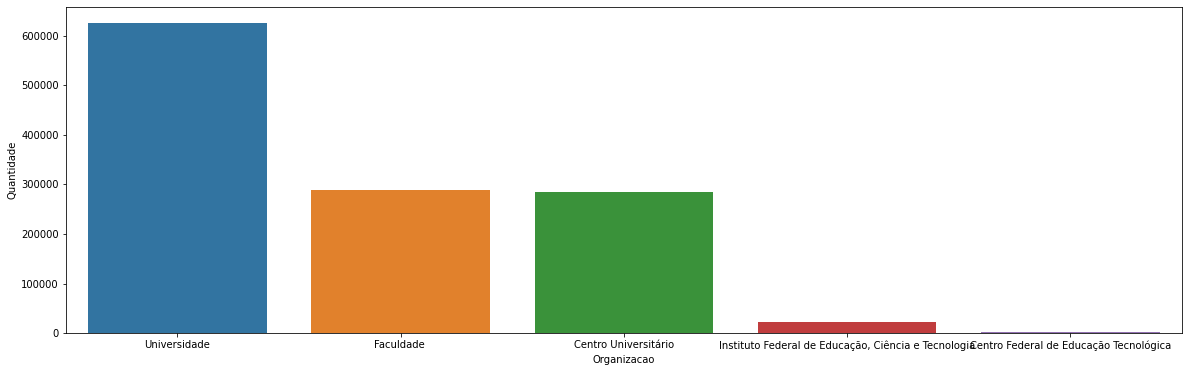

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

fig_dims = (20, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=df['Organizacao'], y=df['Quantidade'], ax=ax)

Universidades são o claro vencedor nessa categoria.

### Pergunta 2: Em média, quanto tempo um aluno demora para iniciar a graduação a partir do fim do Ensino Médio?

In [23]:
df = pd.read_sql(
  """
  SELECT Inicio_graduacao, Fim_EM
  FROM Prova
  WHERE Inicio_graduacao >= Fim_EM
  """,
  engine
)

df['Intervalo'] = df['Inicio_graduacao'] - df['Fim_EM']
df = df[df.Intervalo < 60]
table = df.groupby('Intervalo').count().drop('Fim_EM', axis=1).rename(columns={'Inicio_graduacao': 'Quantidade'})
table.head()

,Quantidade
Intervalo,
0,22607
1,417189
2,163719
3,102143
4,77281


A média é de aproximadamente 5 anos de intervalo


/home/eduardo/anaconda3/envs/dw/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Intervalo'>

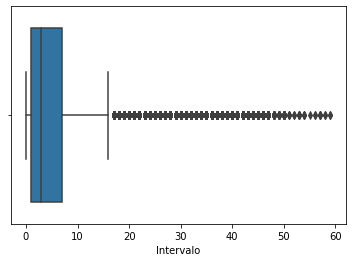

In [24]:
print('A média é de aproximadamente', int(np.round(np.mean(df.Intervalo.to_numpy()))), 'anos de intervalo')
sns.boxplot(df.Intervalo)

### Pergunta 3: Quais estados apresentam maior participação no ENADE, ou seja, quais estados possuem mais alunos em algum tipo de Ensino Superior?

In [25]:
df = pd.read_sql(
  """
  SELECT Estado.Nome as Estado, count(Estado) as Quantidade
  FROM Prova INNER JOIN Estado
  ON Prova.Estado = Estado.Id
  GROUP BY Estado
  ORDER BY Quantidade DESC
  """,
  engine
)
df

,Estado,Quantidade
0,São Paulo,309034
1,Minas gerais,136110
2,Rio de Janeiro,112957
3,Paraná,96797
4,Rio Grande do Sul,66953
5,Santa Catarina,55689
6,Bahia,51261
7,Pernambuco,46121
8,Ceará,40571
9,Goiás,36784


<AxesSubplot:xlabel='Estado', ylabel='Quantidade'>

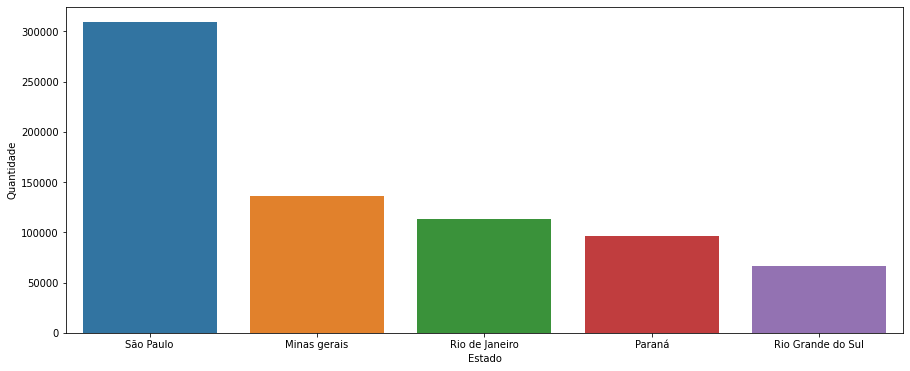

In [26]:
# Vou plotar apenas os 5 maiores
show = df[df.index <5]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=show['Estado'], y=show['Quantidade'], ax=ax)

Claramente, o estado de São Paulo é disparado o que põe mais alunos na universidade.

### Pergunta 4: Há alguma relação entre o turno e a idade dos participantes?

In [27]:
df = pd.read_sql(
  """
  SELECT Turno.Nome as Turno, Prova.Idade as Idade
  FROM Prova INNER JOIN Turno
  ON Prova.Turno = Turno.Id
  ORDER BY Idade ASC
  """,
  engine
)
df = df[df.Idade >= 16]
df

,Turno,Idade
5,Noturno,16
6,Noturno,17
7,Integral,17
8,Noturno,17
9,Vespertino,17
...,...,...
1225981,Noturno,87
1225982,Matutino,90
1225983,Noturno,94
1225984,Matutino,94


<AxesSubplot:xlabel='Turno', ylabel='Idade'>

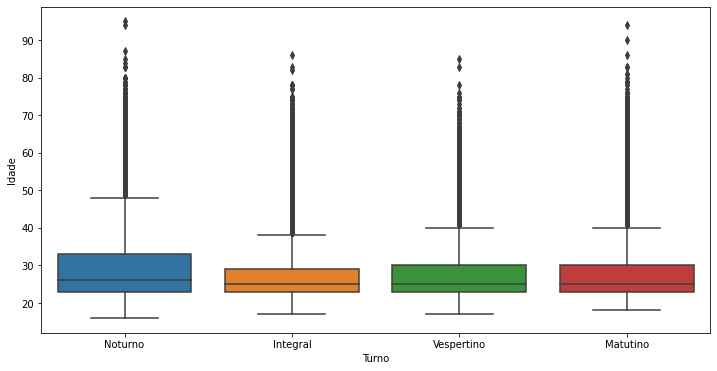

In [28]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x=df.Turno, y=df.Idade, ax=ax)

Com esse gráfico podemos ver que a idade não varia tanto com o turno, mas ele confirma a tese de que pessoas mais velhas tendem a ir para o turno Noturno.

### Pergunta 5: Quais grupos menos participaram da Prova, isto é, quais tipos de cursos tem menor formação de profissionais?

In [29]:
df = pd.read_sql(
  """
  SELECT Grupo.Nome as Grupo, count(*) as Quantidade
  FROM Prova INNER JOIN Grupo
  on Prova.Grupo = Grupo.Id
  GROUP BY Grupo
  ORDER BY Quantidade ASC
  """, 
  engine
)
df

,Grupo,Quantidade
0,TECNOLOGIA EM SEGURANÇA NO TRABALHO,100
1,TECNOLOGIA EM GESTÃO HOSPITALAR,439
2,Matemática (Bacharelado),508
3,Letras-Português (Bacharelado),698
4,Física (Bacharelado),760
...,...,...
84,ARQUITETURA E URBANISMO,49087
85,ENGENHARIA CIVIL,89670
86,ADMINISTRAÇÃO,91252
87,Pedagogia (Licenciatura),104068


<AxesSubplot:xlabel='Grupo', ylabel='Quantidade'>

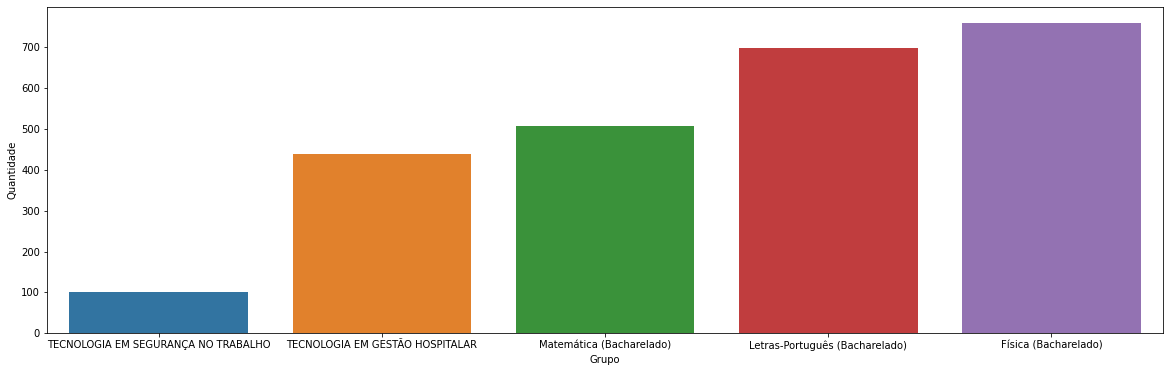

In [30]:
# Vou plotar apenas os 5 menores
show = df[df.index <5]

fig_dims = (20, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=show['Grupo'], y=show['Quantidade'], ax=ax)

Fato interessante a se perceber é que três cursos de licenciatura muito forte são poucos procurados para o caso de bacharelado, isto é, compõe os 5 grupos com menor formação de profissionais.

## Questão 6

**A proposta de aprendizado é a seguinte: dados os dados (Idade, Estado, Grupo, Turno, Organizacao e Modalidade), prever qual o sexo do aluno.**

Aqui utilizo a biblioteca [scikit-learn](https://scikit-learn.org/) para fazer a classificação e análise dos dados.

Para o treinamento do modelo apliquei a técnica de divisão _hold-out_ separando o conjunto de treino e teste na proporção de 80%.

Para o primeiro momento utilizei uma [árvore de decisão](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) padrão do sklearn. 

Em seguida, faço uma varredura manual por hiperparâmetros e verifico que o `max-depth` de 13 produziu o melhor resultado.

In [31]:
df = pd.read_sql(
  """
  SELECT Idade, Estado, Organizacao, Modalidade, Turno, Grupo, Sexo
  FROM Prova
  WHERE Idade >= 16
  """,
  engine
)

In [32]:
df['Sexo'] = df['Sexo'].apply(lambda x: 1 if x == 'F' else 0)
df.head()

,Idade,Estado,Organizacao,Modalidade,Turno,Grupo,Sexo
0,26,51,10028,1,3,5710,1
1,23,51,10028,1,3,5710,1
2,23,51,10028,1,3,5710,0
3,23,51,10028,1,3,5710,0
4,24,51,10028,1,3,5710,0


In [33]:
X = df.iloc[:, :6]
y = df.Sexo

### Tentativa 1

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = DecisionTreeClassifier(random_state=42)

classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [35]:
from sklearn.metrics import accuracy_score, precision_score

y_pred = classifier.predict(X_test)
print('Acuracia: ', accuracy_score(y_test, y_pred))
print('Precisao: ', precision_score(y_test, y_pred))

Acuracia:  0.6834463716929653
Precisao:  0.7113152500157418


### Tentativa 2

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = DecisionTreeClassifier(random_state=42, max_depth=13)

classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=13, random_state=42)

In [37]:
from sklearn.metrics import accuracy_score, precision_score

y_pred = classifier.predict(X_test)
print('Acuracia: ', accuracy_score(y_test, y_pred))
print('Precisao: ', precision_score(y_test, y_pred))

Acuracia:  0.70142375314543
Precisao:  0.7137937631528601


## Questão 7

Abaixo, segue todas as ferramentas utilizadas e o motivo da escolha:
- [Python](https://www.python.org/): familiaridade com a linguagem e praticidade nos fluxos de treinamento de modelos e visualização de dados, além de integrações com bancos relacionais. 
- [Jupyter notebook](https://jupyter.org/): produzir um trabalho iterativo com relatório junto do código.
- [Pandas](pandas.pydata.org/): praticidade no uso de dataframes e integração com SQL e visualização de dados.
- [Seaborn](https://seaborn.pydata.org/): facilidade de usar e beleza das visualizações, além de integração com pandas.
- [SQLite](https://www.sqlite.org/index.html): banco leve e super simples de usar.
- [SQLAlchemy](https://www.sqlalchemy.org/): integração com python o tornou fácil de utilizar em ambiente jupyter.
- [Scikit-learn](https://scikit-learn.org/): familiaridade e praticidade no treinamento de modelos simples.
- [Tqdm](https://tqdm.github.io/): facilidade na criação de barras de progresso.